# Multivariate Hyperbolic Secant Mixture modelの推定
+ モデル:
    + $p(x|w) = \sum_{k=1}^K a_k \prod_{j = 1}^M \frac{\sqrt{s_{kj}}}{2} \frac{1}{\cosh(\frac{s_{kj}}{2}(x_j - b_{kj}))}$
    + $x, b_k \in \mathbb{R}^M, s_k \in \mathbb{R}_+^M$
+ 事前分布:
    + $\varphi(w) = Dir(a|\{ \alpha_k \}_{k=1}^K) \prod_{k=1}^K N(b_k|0, (s_k \beta_k)^{-1} ) Gam(s_k|\gamma_k, \delta_k)$
+ アルゴリズム
   1. 以下の初期化を行う:
       + $g_{ikj}(\eta), v_{ikj}(\eta), h_{ik}(\xi), u_{ik}(\xi)$
   2. 以下を計算する
       + $\hat{\alpha}_k = \alpha_k + \sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\beta}_{kj} = \beta_k + \sum_{i=1}^n -2v_{ikj}(\eta)$
       + $\hat{m}_{kj} = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n -2v_{ik}(\eta)x_i$
       + $\hat{\gamma}_{kj} = \gamma_k + \frac{1}{2}\sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\delta}_{kj} = \delta_k + \sum_{i=1}^n -v_{ikj}(\eta)x_{ij}^2 - \frac{\hat{\beta}_{kj}}{2}\hat{m}_{kj}^2$
   3. 以下を計算する
       + $g_{ikj}(\eta) = \frac{\hat{\gamma}_{kj}}{\hat{\delta}_{kj}} (x_{ij} - \hat{m}_{kj})^2 + \frac{1}{\hat{\beta}_{kj}}$
       + $v_{ikj}(\eta) = -u_{ik}(\xi)\frac{ \tanh(\sqrt{g_{ikj}(\eta)}/2) }{4\sqrt{g_{ikj}(\eta)}}$
   4. 以下を計算する
       + $h_{ik}(\xi) = \psi(\hat{\alpha}_k) - \psi(\sum_{l=1}^K \hat{\alpha}_l) + \frac{1}{2} \sum_{j=1}^M (\psi(\hat{\gamma}_{kj}) - \log(\hat{\delta}_{kj})) - \sum_{j=1}^M \log(\cosh(\sqrt{g_{ikj}(\eta)}/2)) $
       + $u_{ik}(\xi) = \frac{ \exp(h_{ik}(\xi)) }{ \sum_{l=1}^K \exp(h_{il}(\xi)) }$
       + ここで,$\psi(x) = \frac{d}{dx}\log \Gamma(x)$
   5. 2.に戻る
   
+ 評価関数$\overline{F}_{\xi, \eta}(x^n)$の値
    + $\overline{F}_{\xi, \eta}(x^n) = - \phi(h(\xi)) - \psi(g(\eta)) + u(\xi) \cdot h(\xi) + v(\eta) \cdot g(\eta) $  
        $+ nM \log 2 \pi + \log \Gamma(\sum_{l = 1}^K \hat{\alpha}_l) - \log \Gamma({\sum_{l = 1}^K\alpha}_l) + \sum_{k=1}^K \log \frac{\Gamma(\alpha_k)}{\Gamma(\hat{\alpha}_k)}$  
        $+ \sum_{k=1}^K \sum_{j=1}^M \bigl\{ \frac{1}{2} \log \frac{\hat{\beta}_{kj}}{\beta_{kj}} + \hat{\gamma}_{kj} \log \hat{\delta}_{kj} - \gamma_{kj} \log \delta_{kj} - \log \Gamma(\hat{\gamma}_{kj}) + \log \Gamma(\gamma_{kj}) \bigr\}$

In [59]:
%matplotlib inline

In [60]:
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, cauchy

## HSMMに従う確率変数を生成する

In [61]:
data_seed = 20190522
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = 0
true_s = np.array([[2, 2], [0.5, 0.5], [1, 1]])
true_b = np.array([[4, 4], [-4, -4], [0, 0]])
n = 2000
M = true_b.shape[1]
np.random.seed(data_seed)

In [62]:
true_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_label_arg = np.argmax(true_label, axis = 1)

In [63]:
def random_hsm(n, loc = 0, scale = 1):
    """
    hyperbolic secant distributionに従う確率変数を生成する
    $Y \sim standard_cauchy(x)$の時,  
    $X = \frac{2}{s}\sinh^{-1}(Y) + b$は,  
    $X \sim p(x) = \frac{s}{2\pi}\frac{1}{\cosh(s(x-b)/2)}$に従うはずなので、その確認を行う
    """
    Y = np.random.standard_cauchy(size=n)
    X = 2/np.sqrt(scale)*np.arcsinh(Y) + loc    
    return X

In [64]:
# x = np.zeros((n, M))
# for i in range(n):
#     for j in range(M):
#         x[i, j] = random_hsm(n=1, loc=true_b[true_label_arg[i],j], scale=true_s[true_label_arg[i],j])

In [65]:
import math
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
#         x[i, j] = np.random.normal(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size=1)        
#         x[i, j] = random_hsm(n = 1, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j])
        x[i, j] = t.rvs(df = 1.5, loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size = 1)
noise_data_num = math.ceil(n*true_delta)
if noise_data_num > 0:
#     x[-noise_data_num:,:] = np.random.uniform(low=-30, high=30, size = noise_data_num*M).reshape(noise_data_num,M)
    x[-noise_data_num:,:] = t.rvs(df = 0.8,size = noise_data_num*M).reshape(noise_data_num,M)

In [66]:
# x = np.zeros((n, M))
# is_outlier = -1*np.ones(n)
# for i in range(n):
#     if np.random.uniform(size=1) < true_delta[true_label_arg[i]]:
# #         x[i] =  (np.random.standard_cauchy(size=1) - true_b[true_label_arg[i]])/true_s[true_label_arg[i]]
#         x[i,:] =  np.random.uniform(low = -10, high = 10, size = M)
#         is_outlier[i] = true_label_arg[i]
#     else:
#         for j in range(M):
#             x[i, j] = np.random.normal(loc=true_b[true_label_arg[i],j], scale=1/true_s[true_label_arg[i],j], size=1)

In [67]:
# from scipy.stats import t
# x = np.zeros((n, M))
# for i in range(n):
#     for j in range(M):
#         x[i, j] = t.rvs(df = 2, loc=true_b[true_label_arg[i],j], scale=true_s[true_label_arg[i],j], size = 1)

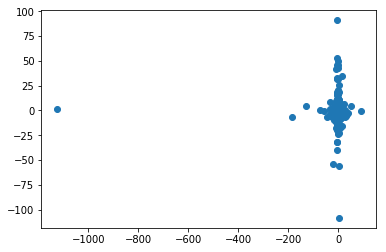

In [68]:
plt.scatter(x[:,0], x[:,1])

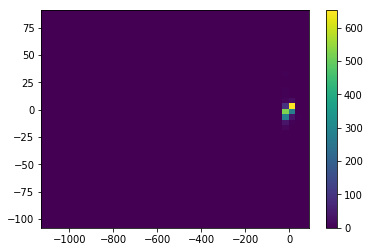

In [69]:
plt.hist2d(x[:,0], x[:,1], bins = 40)
plt.colorbar()
plt.show()

In [70]:
def simple_2dhist(k:int = 0):
    max_val = x.max(axis = 0)
    min_val = x.min(axis = 0)    
    plt.hist2d(x[np.where(true_label_arg == k),0].squeeze(), x[np.where(true_label_arg == k),1].squeeze(), range = [[min_val[0], max_val[0]], [min_val[1], max_val[1]]], bins = 40)
    plt.colorbar()
    plt.xlim(left = min_val[0], right = max_val[0])
    plt.ylim(bottom = min_val[1], top = max_val[1])
    plt.show()
    pass

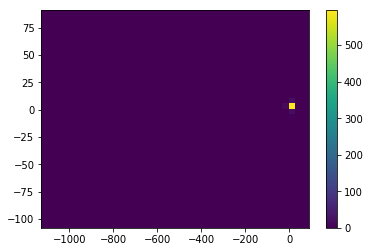

In [71]:
simple_2dhist(0)

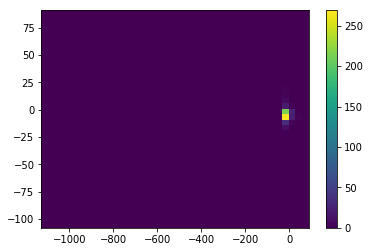

In [72]:
simple_2dhist(1)

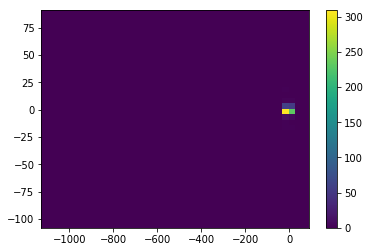

In [73]:
simple_2dhist(2)

# 学習を行う

In [74]:
def fit_lva_gmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    (n, M) = train_X.shape
    ### 計算前の設定
    expand_x = np.repeat(x, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### learning_seedsに指定があれば乱数の種を設定する
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### 初期値の設定
#         est_h_xi = np.random.gamma(shape = 1, size = (n, K))
#         est_u_xi = np.exp(est_h_xi) / np.repeat(np.exp(est_h_xi).sum(axis = 1), K).reshape(n,K)
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)
    
        ### 学習開始
        for ite in range(iteration):
            ### 事後分布の更新
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = np.repeat(pri_beta + est_u_xi.sum(axis = 0), M).reshape(K,M)
            est_m = est_u_xi.T @ x / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta + est_u_xi.T @ (x**2) /2 - est_beta / 2 * est_m**2
            ### 対数双曲線関数の更新
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))

            ### 隠れ変数の更新
            est_h_xi = -M/2*np.log(2*np.pi) + np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - est_g_eta.sum(axis = 2)/2
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### エネルギーの計算
            energy[ite] = - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["alpha"] = est_alpha
            result["mu"] = est_m
            result["beta"] = est_beta
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [75]:
def fit_lva_hsmm(train_X:np.ndarray, K:int,
                 pri_alpha = 0.1, pri_beta = 0.001, pri_gamma = 2, pri_delta = 2,
                 iteration = 1000, restart_num:int = 5, learning_seeds:list = None):
    (n, M) = train_X.shape
    ### 計算前の設定
    expand_x = np.repeat(x, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension

    min_energy = np.inf
    result = dict()
    
    for restart in range(restart_num):
        ### learning_seedsに指定があれば乱数の種を設定する
        if learning_seeds is not None and len(learning_seeds) >= restart:
            np.random.seed(learning_seeds[restart])

        energy = np.zeros(iteration)
        ### 初期値の設定
#         est_h_xi = np.random.gamma(shape = 1, size = (n, K))
#         est_u_xi = np.exp(est_h_xi) / np.repeat(np.exp(est_h_xi).sum(axis = 1), K).reshape(n,K)
        est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)

        est_g_eta = np.abs(np.random.normal(size=(n,K,M)))
        est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

        ### 学習開始
        for ite in range(iteration):
            ### 事後分布の更新
            est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
            est_beta = pri_beta + (-2*est_v_eta.sum(axis = 0))
            est_m = -2 * (expand_x * est_v_eta).sum(axis = 0) / est_beta
            est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
            est_delta = pri_delta - (expand_x**2 * est_v_eta).sum(axis = 0) - est_beta / 2 * est_m**2
            ### 対数双曲線関数の更新
            est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
            est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

            ### 隠れ変数の更新
            sqrt_g_eta = np.sqrt(est_g_eta)
            est_h_xi = np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)).sum(axis = 2)
            max_h_xi = est_h_xi.max(axis = 1)
            norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
            est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

            ### エネルギーの計算
            energy[ite] = (np.repeat(est_u_xi, M).reshape(n, K, M) * (sqrt_g_eta/2 +  np.log( (1 + np.exp(-2*sqrt_g_eta/2 ))/2)) ).sum() - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum() + (est_v_eta * est_g_eta).sum()
            energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
            energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
        
        print(energy[-1])        
        if energy[-1] < min_energy:
            min_energy = energy[-1]
            result["alpha"] = est_alpha
            result["beta"] = est_beta
            result["mu"] = est_m
            result["gamma"] = est_gamma
            result["delta"] = est_delta
            result["h_xi"] = est_h_xi
            result["u_xi"] = est_u_xi
            result["g_eta"] = est_g_eta
            result["v_eta"] = est_v_eta            
            result["energy"] = energy
            if learning_seeds is not None and len(learning_seeds) >= restart:
                result["seed"] = learning_seeds[restart]
    return result

In [76]:
### 初期設定を行う
iteration = 1000
learning_seeds = [20190511, 20190512, 20190513, 20190514, 20190515]

## 学習モデルのコンポーネントの数
K = 5

## ハイパーパラメータ
pri_alpha = 0.1
pri_beta = 0.001
pri_gamma = 2
pri_delta = 2



In [77]:
hsmm_result = fit_lva_hsmm(x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds=learning_seeds)

3166.655202924195
3166.6552029241684
3166.6552029241966
3166.655202924187
3166.655202924168


In [78]:
{
    "est_ratio": hsmm_result["alpha"] / sum(hsmm_result["alpha"]),
    "est_mean": hsmm_result["mu"],
    "est_precision": hsmm_result["gamma"] / hsmm_result["delta"]
}

{'est_ratio': array([0.06037125, 0.28806377, 0.02743401, 0.29954877, 0.3245822 ]),
 'est_mean': array([[-1.11082275,  0.99868815],
        [-3.97688863, -3.91407902],
        [-3.51752479, -1.75304691],
        [ 4.01792102,  3.97995424],
        [ 0.01833379,  0.06403805]]),
 'est_precision': array([[3.24983261e-01, 2.84353134e-02],
        [8.42820850e-01, 1.21162275e+00],
        [2.84318767e-03, 6.47963881e-01],
        [1.31992508e+01, 1.12619452e+01],
        [3.30996543e+00, 3.57341898e+00]])}

In [79]:
gmm_result = fit_lva_gmm(x, K, pri_alpha = pri_alpha, pri_beta = pri_beta, pri_gamma = pri_gamma, pri_delta = pri_delta, learning_seeds = learning_seeds)

7087.406732699109
7030.91613515695
7030.916135156957
7030.91613515696
7030.9161351569655


In [80]:
{
    "est_ratio": gmm_result["alpha"] / sum(gmm_result["alpha"]),
    "est_mean": gmm_result["mu"],
    "est_precision": gmm_result["gamma"] / gmm_result["delta"]
}

{'est_ratio': array([0.28013132, 0.27763826, 0.33157763, 0.00963835, 0.10101444]),
 'est_mean': array([[  4.05500903,   4.0195547 ],
        [ -3.98602478,  -3.81360123],
        [  0.19850529,   0.26769412],
        [-70.15414833,  -1.70183528],
        [ -1.30532928,   0.08169193]]),
 'est_precision': array([[1.91362708e+00, 1.61092148e+00],
        [1.22548891e-01, 1.52239982e-01],
        [3.46648833e-01, 3.40317810e-01],
        [1.84261602e-05, 1.05086781e-01],
        [1.03194355e-02, 3.31645876e-03]])}

## クラスタ確率の評価
+ クラスタの番号は入れ替え対称性があるので、全ての置換の中で真のラベルと一致している数が多いもので対応付けを行う

In [81]:
import itertools
label_prob_gmm = gmm_result["u_xi"]
if noise_data_num > 0:
    target_label_arg = true_label_arg[:-noise_data_num]
    label_arg_gmm = np.argmax(label_prob_gmm, axis = 1)[:-noise_data_num]
else:
    target_label_arg = true_label_arg
    label_arg_gmm = np.argmax(label_prob_gmm, axis = 1)

max_correct_num_gmm = 0
for perm in list(itertools.permutations(range(K), K)):
    permed_label_arg_gmm = label_arg_gmm.copy()
    for i in range(len(perm)):
        permed_label_arg_gmm[label_arg_gmm == i] = perm[i]
    correct_num_gmm = (permed_label_arg_gmm == target_label_arg).sum()
    if correct_num_gmm > max_correct_num_gmm:
        max_correct_num_gmm = correct_num_gmm
        max_perm_gmm = perm
        max_label_arg_gmm = permed_label_arg_gmm

In [82]:
import itertools
label_prob_hsmm = hsmm_result["u_xi"]
if noise_data_num > 0:
    target_label_arg = true_label_arg[:-noise_data_num]
    label_arg_hsmm = np.argmax(label_prob_hsmm, axis = 1)[:-noise_data_num]    
else:
    target_label_arg = true_label_arg
    label_arg_hsmm = np.argmax(label_prob_hsmm, axis = 1)
max_correct_num_hsmm = 0
for perm in list(itertools.permutations(range(K), K)):
    permed_label_arg_hsmm = label_arg_hsmm.copy()
    for i in range(len(perm)):
        permed_label_arg_hsmm[label_arg_hsmm == i] = perm[i]
    correct_num_hsmm = (permed_label_arg_hsmm == target_label_arg).sum()
    if correct_num_hsmm > max_correct_num_hsmm:
        max_correct_num_hsmm = correct_num_hsmm
        max_perm_hsmm = perm
        max_label_arg_hsmm = permed_label_arg_hsmm

In [83]:
max_correct_num_gmm

1633

In [84]:
max_correct_num_hsmm

1702

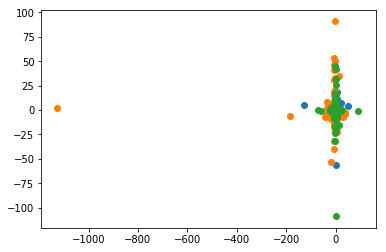

In [85]:
for i in range(K):
    if noise_data_num > 0:
        plt.scatter(x[np.where(true_label_arg[:-noise_data_num] == i)[0],0], x[np.where(true_label_arg[:-noise_data_num] == i)[0],1])
    else:
        plt.scatter(x[np.where(true_label_arg == i)[0],0], x[np.where(true_label_arg == i)[0],1])        
plt.show()

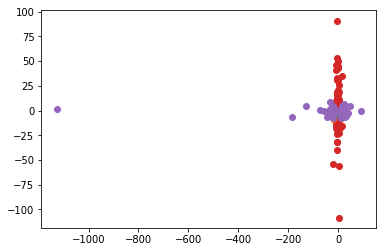

In [86]:
for i in range(K):
    if noise_data_num > 0:
        plt.scatter(x[np.where(max_label_arg_hsmm[:-noise_data_num] == i)[0],0], x[np.where(max_label_arg_hsmm[:-noise_data_num] == i)[0],1])
    else:
        plt.scatter(x[np.where(max_label_arg_hsmm == i)[0],0], x[np.where(max_label_arg_hsmm == i)[0],1])
    
plt.show()

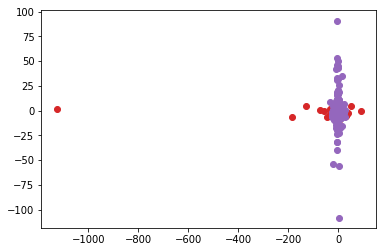

In [87]:
for i in range(K):
    if noise_data_num > 0:
        plt.scatter(x[np.where(max_label_arg_gmm[:-noise_data_num] == i)[0],0], x[np.where(max_label_arg_gmm[:-noise_data_num] == i)[0],1])
    else:
        plt.scatter(x[np.where(max_label_arg_gmm == i)[0],0], x[np.where(max_label_arg_gmm == i)[0],1])    
plt.show()